# Классификация покемонов

## Предобработка данных

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np             
import sklearn  

In [12]:
data = pd.read_csv("pokemon.csv")

data['type2'].fillna(data['type2'].mode().iloc[0], inplace=True)
data.isna().sum()
data.fillna(data.median(axis = 0), axis=0 , inplace=True)
data.isna().sum()

del data['name']
del data['japanese_name']
del data['abilities']
del data['pokedex_number']
del data['generation']
del data['classfication']
del data['capture_rate']

num_cols = [x for x in data.columns if data[x].dtype in ['int64', 'float64'] and x != 'is_legendary']
main_data = data.copy(deep=True)
for i in range(0, 30):
    main_data[num_cols[i]].quantile([0.005,.01,.05,.1,.5,.9,.95,.99,.995])
    rows_to_drop = main_data[(main_data[num_cols[i]] < main_data[num_cols[i]].quantile(0.005)) | (main_data[num_cols[i]] > main_data[num_cols[i]].quantile(0.995))].index
    main_data = main_data.drop(rows_to_drop)
pass

department_dummies = pd.get_dummies(main_data['type1'])
main_data = pd.concat((main_data, department_dummies), axis=1)
main_data = main_data.drop(['type1'], axis=1)

department_dummies = pd.get_dummies(main_data['type2'])
main_data = pd.concat((main_data, department_dummies), axis=1)
main_data = main_data.drop(['type2'], axis=1)

main_data.columns = [*main_data.columns[:-18], 'bug2', 'dark2', 'dragon2', 'electric2', 'fairy2', 'fighting2', 'fire2', 'flying2', 'ghost2', 'grass2', 'ground2', 'ice2', 'normal2', 'poison2', 'psychic2', 'rock2', 'steel2', 'water2']

data_stand = (main_data - main_data.mean(axis = 0))/main_data.std(axis = 0)

# Полносвязная неглубокая нейронная сеть


Разобьем данные на обучающую и тестовую выборки

In [14]:
from sklearn.model_selection import train_test_split

y = main_data['is_legendary']
X = data_stand.drop(['is_legendary'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)
N, d = x_train.shape
N, d

(584, 67)

In [15]:
N, d = x_test.shape
N, d

(147, 67)

Обучим нейронную сеть, соcтоящую из одного слоя и подберем наилучшее количество нейронов.

In [50]:
from sklearn.neural_network import MLPClassifier

test_err = []
train_err = []
for x in range(1, 100, 10):
    mlp_model = MLPClassifier(hidden_layer_sizes = (x, ), random_state = 42, max_iter = 10000)
    mlp_model.fit(x_train, y_train)

    y_train_pred = mlp_model.predict(x_train)
    y_test_pred = mlp_model.predict(x_test)
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))

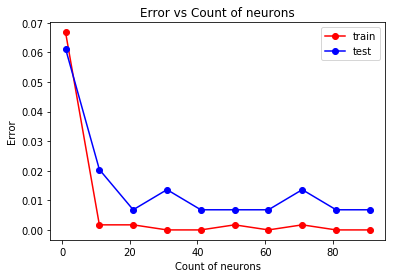

In [52]:
plt.plot(range(1, 100, 10), train_err, 'r-o', label = 'train')
plt.plot(range(1, 100, 10), test_err, 'b-o', label = 'test')
plt.title('Error vs Count of neurons')
plt.xlabel('Count of neurons')
plt.ylabel('Error')
plt.legend()
pass

По графику видно, что ошибка минимизируется при количестве нейронов, равном 100.

In [28]:
mlp_model = MLPClassifier(hidden_layer_sizes = (100, ), random_state = 42, max_iter = 10000)
mlp_model.fit(x_train, y_train)

score1 = np.mean(y_train != mlp_model.predict(x_train))
score2 = np.mean(y_test  != mlp_model.predict(x_test))
print("Ошибка на обучающей выборке: ", score1)
print("Ошибка на тестовой выборке: ", score2)

Ошибка на обучающей выборке:  0.0
Ошибка на тестовой выборке:  0.006802721088435374


Теперь подберем оптимальный параметр для 2 слоев

In [53]:
test_err = []
train_err = []
for x in range(1, 500, 50):
    mlp_model = MLPClassifier(hidden_layer_sizes = (x, 100), random_state = 42, max_iter = 10000)
    mlp_model.fit(x_train, y_train)

    y_train_pred = mlp_model.predict(x_train)
    y_test_pred = mlp_model.predict(x_test)
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))

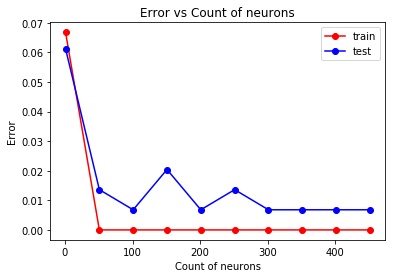

In [54]:
plt.plot(range(1, 500, 50), train_err, 'r-o', label = 'train')
plt.plot(range(1, 500, 50), test_err, 'b-o', label = 'test')
plt.title('Error vs Count of neurons')
plt.xlabel('Count of neurons')
plt.ylabel('Error')
plt.legend()
pass

Оптимальное количесво нейронов - 350.

In [33]:
mlp_model = MLPClassifier(hidden_layer_sizes = (350, 100), random_state = 42, max_iter = 10000)
mlp_model.fit(x_train, y_train)

score1 = np.mean(y_train != mlp_model.predict(x_train))
score2 = np.mean(y_test  != mlp_model.predict(x_test))
print("Ошибка на обучающей выборке: ", score1)
print("Ошибка на тестовой выборке: ", score2)

Ошибка на обучающей выборке:  0.0
Ошибка на тестовой выборке:  0.006802721088435374


Подберем параметр alpha для полученных нейронных сетей.

Для нейронной сети с одним слоем:

In [57]:
from sklearn.metrics import accuracy_score

test_err = []
train_err = []
train_acc = []
test_acc = []

for alpha in np.arange(0.0001, 0.01, 0.001):
    mlp_model = MLPClassifier(alpha = alpha, hidden_layer_sizes = (100, ), max_iter=10000, random_state = 42)
    mlp_model.fit(x_train, y_train)

    y_train_pred = mlp_model.predict(x_train)
    y_test_pred = mlp_model.predict(x_test)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))

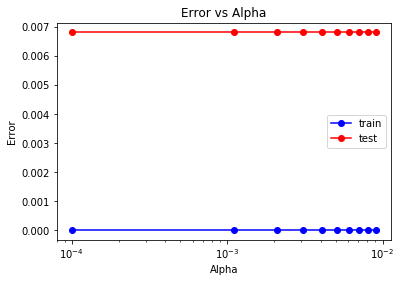

In [58]:
plt.semilogx(np.arange(0.0001, 0.01, 0.001), train_err, 'b-o', label = 'train')
plt.semilogx(np.arange(0.0001, 0.01, 0.001), test_err, 'r-o', label = 'test')
plt.title('Error vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Error')
plt.legend()
pass

In [44]:
mlp_model = MLPClassifier(hidden_layer_sizes = (100, ), alpha = 0.01, random_state = 42, max_iter = 10000)
mlp_model.fit(x_train, y_train)

score1 = np.mean(y_train != mlp_model.predict(x_train))
score2 = np.mean(y_test  != mlp_model.predict(x_test))
print("Ошибка на обучающей выборке: ", score1)
print("Ошибка на тестовой выборке: ", score2)

Ошибка на обучающей выборке:  0.0
Ошибка на тестовой выборке:  0.006802721088435374


In [59]:
test_err = []
train_err = []
train_acc = []
test_acc = []

for alpha in np.arange(0.0001, 0.01, 0.001):
    mlp_model = MLPClassifier(alpha = alpha, hidden_layer_sizes = (350, 100), max_iter=10000, random_state = 42)
    mlp_model.fit(x_train, y_train)

    y_train_pred = mlp_model.predict(x_train)
    y_test_pred = mlp_model.predict(x_test)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))

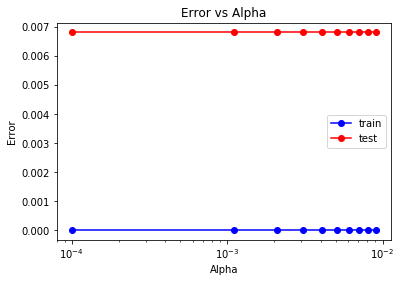

In [60]:
plt.semilogx(np.arange(0.0001, 0.01, 0.001), train_err, 'b-o', label = 'train')
plt.semilogx(np.arange(0.0001, 0.01, 0.001), test_err, 'r-o', label = 'test')
plt.title('Error vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Error')
plt.legend()
pass

In [61]:
mlp_model = MLPClassifier(hidden_layer_sizes = (350, 100), alpha = 0.01, random_state = 42, max_iter = 10000)
mlp_model.fit(x_train, y_train)

score1 = np.mean(y_train != mlp_model.predict(x_train))
score2 = np.mean(y_test  != mlp_model.predict(x_test))
print("Ошибка на обучающей выборке: ", score1)
print("Ошибка на тестовой выборке: ", score2)

Ошибка на обучающей выборке:  0.0
Ошибка на тестовой выборке:  0.006802721088435374


Оптимальное число нейронов при одном слое 100, при двух слоях оптимальное число нейронов 350 на первом и 100 на втором слое. для обеих моделей ошибка составила 0.0 на обучащей выборке и ~0.0068 на тестовой. Таким образом нейронная сеть показала один из лучших резульатов на равне со случайным лесом.